# 1-D CNN model for CAP classification 
- Authors - Shruti Murarka, Aditya Wadichar

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
loadpkl=True

## Dataset

In [4]:
from os import listdir
# csvs=[str(i)+' Balanced data/'+n for i,n in enumerate(listdir('Balanced Data'))]
csvs=['Balanced data/'+i for i in listdir('Balanced Data')]
csvs

['Balanced data/bal_all.csv',
 'Balanced data/bal_healthy.csv',
 'Balanced data/bal_healthy_F4C4.csv',
 'Balanced data/bal_ins.csv',
 'Balanced data/bal_narco.csv',
 'Balanced data/bal_nfle.csv',
 'Balanced data/bal_plm.csv',
 'Balanced data/bal_rbd.csv',
 'Balanced data/bal_sdb.csv']

In [5]:
import pickle
enf=[1, 3, 4, 5, 6, 7, 8]
if loadpkl:
    print('Loading bal_categories.pkl')
    with open('bal_categories.pkl', 'rb') as f:
        x_bal,y_bal,csvs = pickle.load(f)
else:
    x_bal_list = []
    y_bal_list = []

    for n,i in enumerate([1, 3, 4, 5, 6, 7, 8]):
        bal_all = np.loadtxt(csvs[i], delimiter=',')
        
        x_bal = bal_all[:, 0:1024]
        y_bal = bal_all[:, 1024]
        
        y_bal = y_bal.reshape(-1, 1)
        y_bal[:] = n
        
        x_bal_list.append(x_bal)
        y_bal_list.append(y_bal)

    x_bal = np.concatenate(x_bal_list, axis=0)
    y_bal = np.concatenate(y_bal_list, axis=0)

    print('Saving to bal_categories.pkl')
    with open('bal_categories.pkl', 'wb') as f:
        pickle.dump([x_bal,y_bal,csvs], f)

# Print the shapes to verify
print(f"x_bal shape: {x_bal.shape}")
print(f"y_bal shape: {y_bal.shape}")

Loading bal_categories.pkl
x_bal shape: (168000, 1024)
y_bal shape: (168000, 1)


In [6]:
# x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, y_bal, test_size = 0.2, shuffle = False)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_bal, y_bal, test_size = 0.2, shuffle = True,stratify=y_bal)

In [7]:
from keras.utils import to_categorical
num_classes = 7
y_train1 = to_categorical(y_train1)
y_test1 = to_categorical(y_test1)

2024-06-09 17:47:09.531547: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 17:47:10.118576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 17:47:11.272150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-09 17:47:12.820387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 17:47:13.081383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 17:47:13.081424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [20]:
import matplotlib.pyplot as plt
def plotaccloss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
unique_values, counts = np.unique(y_train1, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0.0: 806400
1.0: 134400


## Paper

### Hyperparameter Optimization

In [22]:
from sklearn.model_selection import KFold
from keras.models import Sequential
import keras.layers as tfl
from keras.utils import to_categorical

param = 16
num_classes = 7  # Number of output classes

kfold = KFold(n_splits=5, shuffle=True, random_state=1) 
fold_no = 1
acc_per_fold1 = []
loss_per_fold1 = []

for train, test in kfold.split(x_train1, y_train1):
    model = Sequential()
    model.add(tfl.Conv1D(filters=32,
                         kernel_size=7,
                         strides=1,
                         padding='same',
                         input_shape=(1024, 1)))

    model.add(tfl.Conv1D(filters=8,
                         kernel_size=3,
                         strides=1,
                         padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size=16,
                            padding='same'))
    model.add(tfl.Conv1D(filters=16,
                         kernel_size=2,
                         strides=1,
                         padding='same'))
    model.add(tfl.Dropout(0.4))
    model.add(tfl.Conv1D(filters=8,
                         kernel_size=2,
                         strides=1,
                         padding='same', activation='relu'))
    model.add(tfl.MaxPool1D(pool_size=4,
                            padding='same'))
    model.add(tfl.Flatten())
    model.add(tfl.Dense(param, activation='relu'))    ## parameter change
    model.add(tfl.Dense(num_classes, activation='softmax'))  # Changed activation and output size
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history1 = model.fit(x_train1[train], y_train1[train],
                         batch_size=75,
                         epochs=50)

    # Generate generalization metrics
    scores1 = model.evaluate(x_train1[test], y_train1[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores1[0]}; {model.metrics_names[1]} of {scores1[1]*100}%')
    acc_per_fold1.append(scores1[1] * 100)
    loss_per_fold1.append(scores1[0])

    # Increase fold number
    fold_no += 1


/home/pece/patrones/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-09 15:56:26.206253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 15:56:26.206393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 15:56:26.206413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Y

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


I0000 00:00:1717966590.934234   37740 service.cc:145] XLA service 0x7f44c000be20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717966590.934306   37740 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-09 15:56:30.979708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 15:56:31.174364: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  30/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1929 - loss: 6.4962  

I0000 00:00:1717966594.513547   37740 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1434/1434 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4334 - loss: 1.7887
Epoch 2/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5199 - loss: 1.3832
Epoch 3/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5300 - loss: 1.3520
Epoch 4/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5390 - loss: 1.3302
Epoch 5/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5448 - loss: 1.3101
Epoch 6/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5510 - loss: 1.2890
Epoch 7/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5564 - loss: 1.2646
Epoch 8/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5621 - loss: 1.2456
Epoch 9/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5621 - loss: 1.2386
Epoch 10/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5667 - loss: 1.2269
Epoch 11/50
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5686 - loss: 1.2199
Epoch 12/50
1434/1434 ━━━━━━━━━━━━━━━━━━

In [27]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold1)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold1[i]} - Accuracy: {acc_per_fold1[i]}%')  
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold1)} (+- {np.std(acc_per_fold1)})')
print(f'> Loss: {np.mean(loss_per_fold1)}')
print('------------------------------------------------------------------------')

#np.savetxt('/content/drive/MyDrive/FYP/Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')
# np.savetxt('Hyper_opti/dense_param4.csv', acc_per_fold1, delimiter=',')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0908420085906982 - Accuracy: 60.93006134033203%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.098961591720581 - Accuracy: 59.82142686843872%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1342484951019287 - Accuracy: 57.946425676345825%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.1084561347961426 - Accuracy: 59.45684313774109%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.129067301750183 - Accuracy: 59.527528285980225%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 59.53645706176758 (+- 0.9547731230517031)
> Loss: 1.1123151063919068
----------------------------

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 1024, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 1024, 8)        │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 64, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 64, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 64, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,751 (14.65 KB)

 Trainable params: 3,751 (14.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4136 - loss: 1.9122 - val_accuracy: 0.5244 - val_loss: 1.3804
Epoch 2/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5186 - loss: 1.3867 - val_accuracy: 0.5364 - val_loss: 1.3697
Epoch 3/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5309 - loss: 1.3570 - val_accuracy: 0.5259 - val_loss: 1.3650
Epoch 4/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5375 - loss: 1.3371 - val_accuracy: 0.5302 - val_loss: 1.3485
Epoch 5/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5425 - loss: 1.3278 - val_accuracy: 0.5343 - val_loss: 1.3282
Epoch 6/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5437 - loss: 1.3159 - val_accuracy: 0.5470 - val_loss: 1.2906
Epoch 7/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5558 - loss: 1.2835 - val_accuracy: 0.5512 - val_loss: 1.2726
Epoch 8/500
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5600 - loss: 

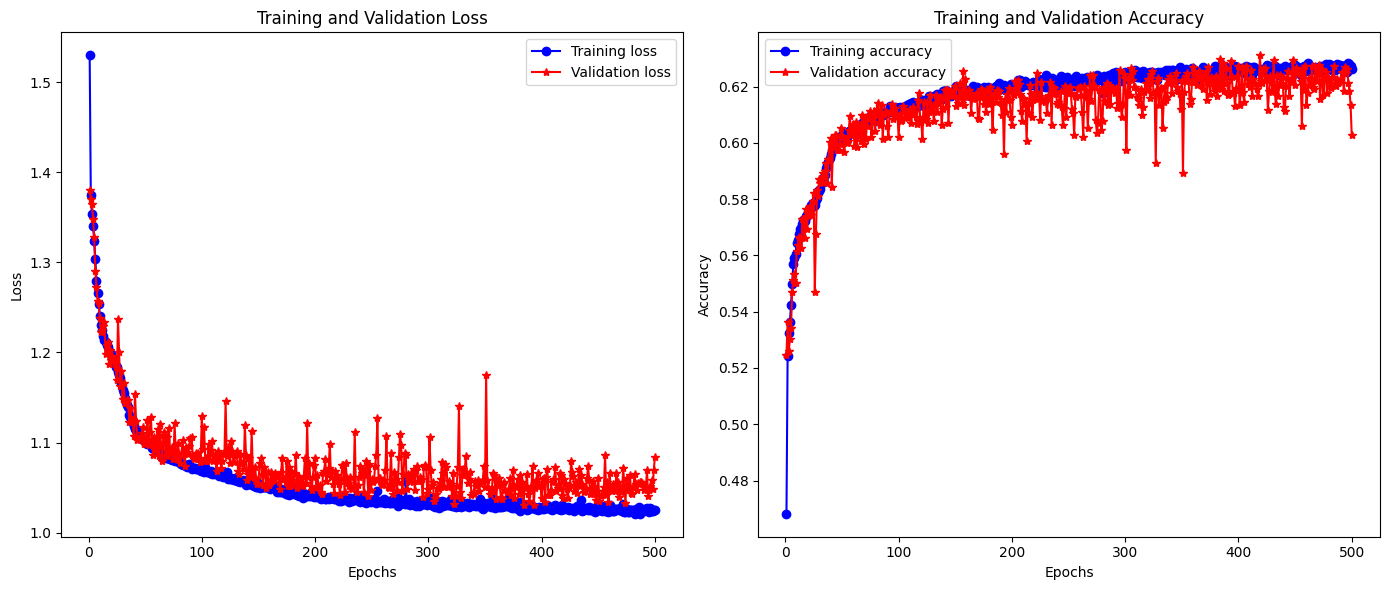

In [29]:
from keras.models import Sequential
import keras.layers as tfl

param = 16
num_classes = 7  # Number of output classes

# Build the model
model = Sequential()
model.add(tfl.Conv1D(filters=32,
                     kernel_size=7,
                     strides=1,
                     padding='same',
                     input_shape=(1024, 1)))

model.add(tfl.Conv1D(filters=8,
                     kernel_size=3,
                     strides=1,
                     padding='same', activation='relu'))
model.add(tfl.MaxPool1D(pool_size=16,
                        padding='same'))
model.add(tfl.Conv1D(filters=16,
                     kernel_size=2,
                     strides=1,
                     padding='same'))
model.add(tfl.Dropout(0.4))
model.add(tfl.Conv1D(filters=8,
                     kernel_size=2,
                     strides=1,
                     padding='same', activation='relu'))
model.add(tfl.MaxPool1D(pool_size=4,
                        padding='same'))
model.add(tfl.Flatten())
model.add(tfl.Dense(param, activation='relu'))    # Parameter change
model.add(tfl.Dense(num_classes, activation='softmax'))  # Changed activation and output size
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(x_train1, y_train1,batch_size=75,epochs=500, validation_split=0.2)

scores = model.evaluate(x_test1,y_test1, verbose=0)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

plotaccloss(history)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step


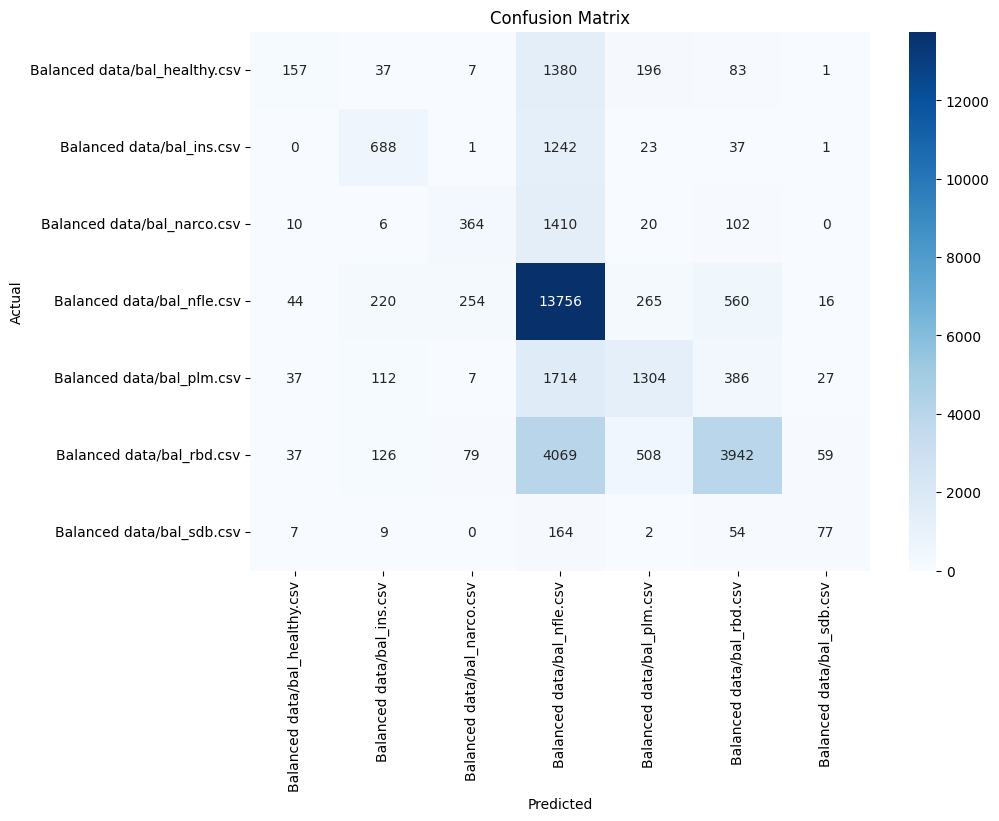

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions
y_pred = model.predict(x_test1)

# Step 2: Convert probabilities to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Step 3: Convert true labels to class indices if they are one-hot encoded
y_true_classes = y_test1.argmax(axis=1)

# Step 4: Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

xyticks=[csvs[i] for i in enf]
# Step 5: Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=xyticks,yticklabels=xyticks)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# model.save('allcsv_classifyv1.keras')

# import keras
# model = keras.models.load_model('allcsv_classifyv1.keras')
